In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sin, cos, sqrt, atan2, radians, sqrt
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import json
from pandas.io.json import json_normalize
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
import datetime




/Users/prachi/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
def load_df(csv_path, nrows=None):
    jsons = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in jsons}, 
                     dtype={'fullVisitorId': 'str'},
                     nrows=nrows)
    
    for column in jsons:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df

In [3]:
train_df = load_df('train.csv')

In [4]:
test_df = load_df('test.csv')

In [5]:
def drop_constant_columns(df):
    for col in df.columns:
        if len(df[col].unique()) == 1:
            df.drop(col,inplace=True,axis=1)
    return df

In [6]:
train_df = drop_constant_columns(train_df)

In [7]:
train_df = train_df.drop(columns=['totals.bounces', 'totals.newVisits', 'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.campaignCode'])

In [8]:
train_df = train_df.apply(pd.to_numeric, errors='ignore')

In [9]:
def process_date(df):
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

In [13]:
def process_visitStartTime(df):
    df["visitStartTime"] = pd.to_datetime(df["visitStartTime"],unit='s')

In [10]:
process_date(train_df)

In [12]:
process_visitStartTime(train_df)

In [11]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,...,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,desktop,False,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,desktop,False,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
2,Organic Search,2016-09-02,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,desktop,False,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
3,Organic Search,2016-09-02,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,UC Browser,desktop,False,...,NaN,NaN,NaN,NaN,(not set),NaN,google + online,organic,NaN,google
4,Organic Search,2016-09-02,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,Chrome,mobile,True,...,NaN,NaN,NaN,NaN,(not set),1.0,(not provided),organic,NaN,google


In [12]:
train_df.shape

(903653, 32)

In [13]:
test_df = drop_constant_columns(test_df)

In [14]:
test_df = test_df.drop(columns=['totals.bounces', 'totals.newVisits', 'trafficSource.adwordsClickInfo.isVideoAd'])

In [15]:
test_df.shape

(804684, 31)

In [16]:
test_df = test_df.apply(pd.to_numeric, errors='ignore')

In [17]:
process_date(test_df)

In [21]:
process_visitStartTime(test_df)

In [18]:
test_df.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,...,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,2017-10-16,6167871330617112363,6167871330617112363_1508151024,1508151024,2,1508151024,Chrome,desktop,False,...,NaN,NaN,NaN,NaN,(not set),1.0,(not provided),organic,NaN,google
1,Organic Search,2017-10-16,0643697640977915618,0643697640977915618_1508175522,1508175522,1,1508175522,Chrome,desktop,False,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
2,Organic Search,2017-10-16,6059383810968229466,6059383810968229466_1508143220,1508143220,1,1508143220,Chrome,desktop,False,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
3,Organic Search,2017-10-16,2376720078563423631,2376720078563423631_1508193530,1508193530,1,1508193530,Safari,mobile,True,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
4,Organic Search,2017-10-16,2314544520795440038,2314544520795440038_1508217442,1508217442,1,1508217442,Safari,desktop,False,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google


In [19]:
train_df['totals.transactionRevenue'].fillna(0, inplace=True)

In [20]:
def impute_page_views(df):
    df['totals.pageviews'].fillna((df['totals.hits']), inplace=True)

In [21]:
impute_page_views(train_df)

In [22]:
impute_page_views(test_df)

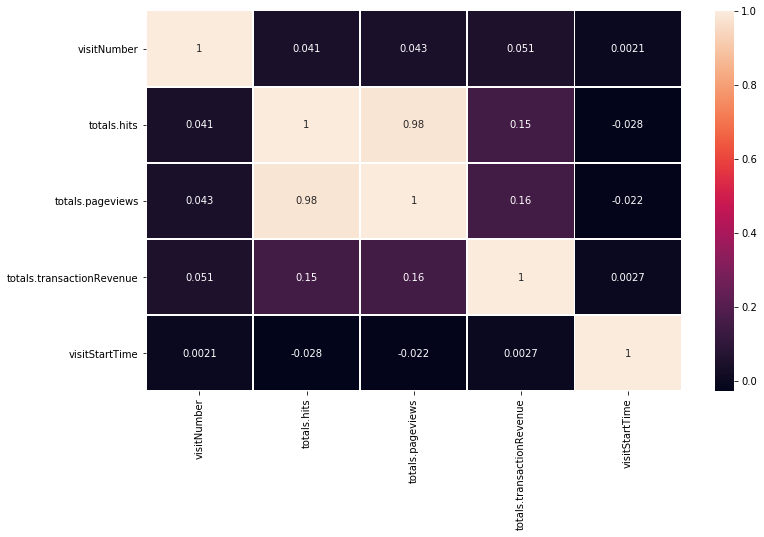

In [75]:
train_sub = train_df[['visitNumber','totals.hits', 'totals.pageviews', 'totals.transactionRevenue', 'visitStartTime']]
Var_Corr = train_sub.corr()
plt.subplots(figsize=(12,7))
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True, linewidths=.5)

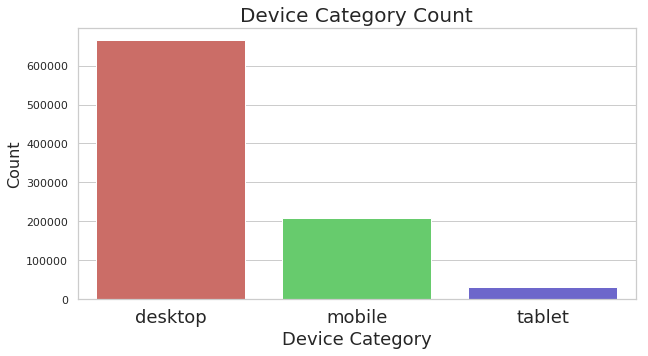

In [70]:

plt.figure(figsize=(10,5))

sns.countplot(train_df["device.deviceCategory"], palette="hls")
plt.title("Device Category Count", fontsize=20)
plt.xlabel("Device Category", fontsize=18)
plt.ylabel("Count", fontsize=16)
plt.xticks(fontsize=18)

plt.show()

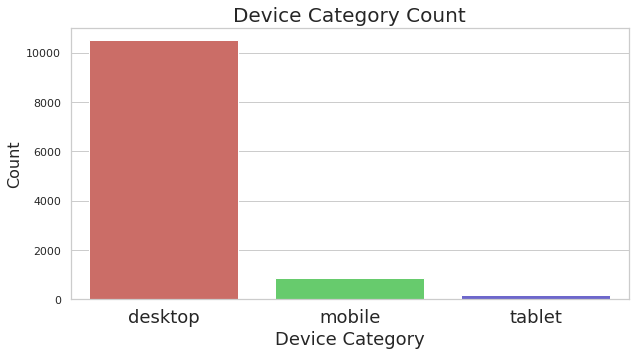

In [72]:
plt.figure(figsize=(10,5))

sns.countplot(train_df[(train_df['totals.transactionRevenue'] > 0)]["device.deviceCategory"], palette="hls") # It's a module to count the category's
plt.title("Device Category Count", fontsize=20) # seting the title size
plt.xlabel("Device Category", fontsize=18) # seting the x label size
plt.ylabel("Count", fontsize=16) # seting the y label size
plt.xticks(fontsize=18) # Adjust the xticks, rotating the labels

plt.show() #use plt.show to render the graph that we did above

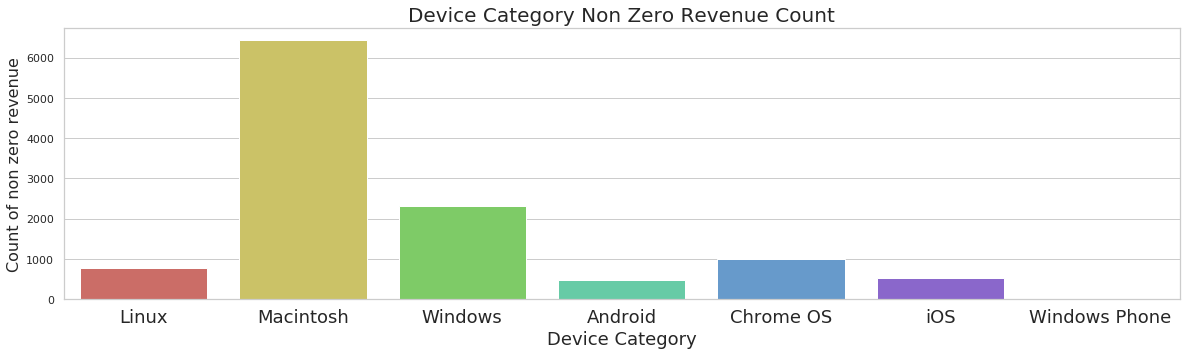

In [86]:
plt.figure(figsize=(20,5))

sns.countplot(train_df[(train_df['totals.transactionRevenue'] > 0)]["device.operatingSystem"], palette="hls") # It's a module to count the category's
plt.title("Device Category Non Zero Revenue Count", fontsize=20) # seting the title size
plt.xlabel("Device Category", fontsize=18) # seting the x label size
plt.ylabel("Count of non zero revenue", fontsize=16) # seting the y label size
plt.xticks(fontsize=18) # Adjust the xticks, rotating the labels

plt.show() #use plt.show to render the graph that we did above

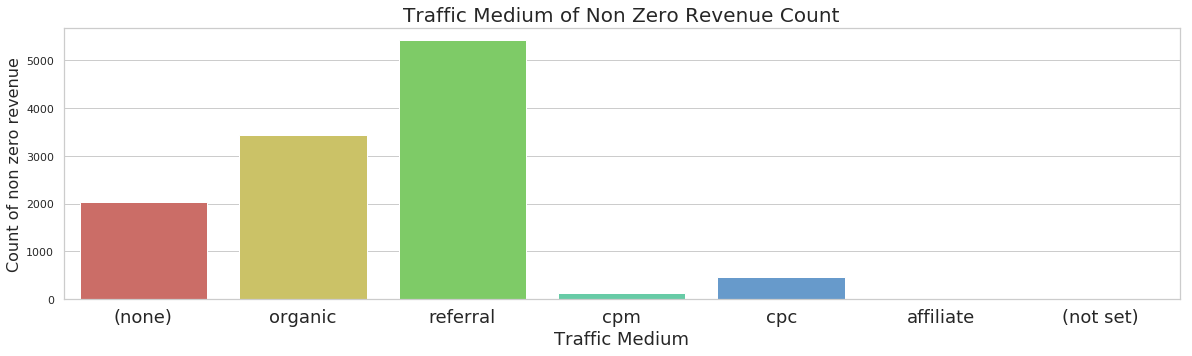

In [89]:
plt.figure(figsize=(20,5))

sns.countplot(train_df[(train_df['totals.transactionRevenue'] > 0)]["trafficSource.medium"], palette="hls") # It's a module to count the category's
plt.title("Traffic Medium of Non Zero Revenue Count", fontsize=20) # seting the title size
plt.xlabel("Traffic Medium", fontsize=18) # seting the x label size
plt.ylabel("Count of non zero revenue", fontsize=16) # seting the y label size
plt.xticks(fontsize=18) # Adjust the xticks, rotating the labels

plt.show() #use plt.show to render the graph that we did above

In [79]:
def plot_categorical(data, col, size=[8 ,4], xlabel_angle=0, title='', max_cat = None):
    '''use this for ploting the count of categorical features'''
    plotdata = data[col].value_counts()
    if max_cat != None:
        plotdata = plotdata[max_cat[0]:max_cat[1]]
    plt.figure(figsize = size)
    sns.barplot(x = plotdata.index, y=plotdata.values)
    plt.title(title)
    plt.ylabel("Count", fontsize=16) 
    if xlabel_angle!=0: 
        plt.xticks(rotation=xlabel_angle)
    plt.show()

In [80]:
def plot_categorical_non_zero_revenue(data, col,size=[8 ,4], xlabel_angle=0, title='', max_cat = None):
    '''use this for ploting the count of categorical features'''
    plotdata = data[(data['totals.transactionRevenue'] > 0)][col].value_counts()
    if max_cat != None:
        plotdata = plotdata[max_cat[0]:max_cat[1]]
    plt.figure(figsize = size)
    sns.barplot(x = plotdata.index, y=plotdata.values)
    plt.title(title)
    plt.ylabel("Non Zero Revenue Count", fontsize=16) # seting the y label size
    if xlabel_angle!=0: 
        plt.xticks(rotation=xlabel_angle)
    plt.show()

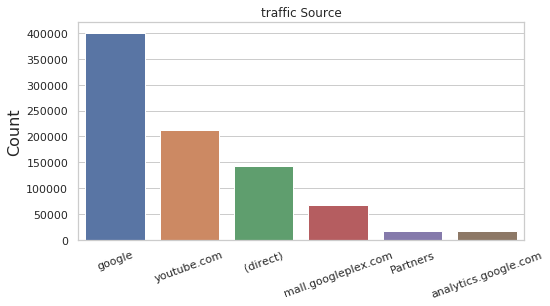

In [107]:
plot_categorical(data=train_df, col='trafficSource.source',size=[8 ,4], xlabel_angle=20, title='traffic Source', max_cat=[0, 6])

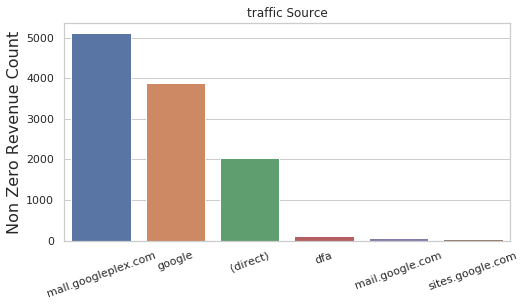

In [108]:
plot_categorical_non_zero_revenue(data=train_df, col='trafficSource.source',size=[8 ,4], xlabel_angle=20, title='traffic Source', max_cat=[0, 6])

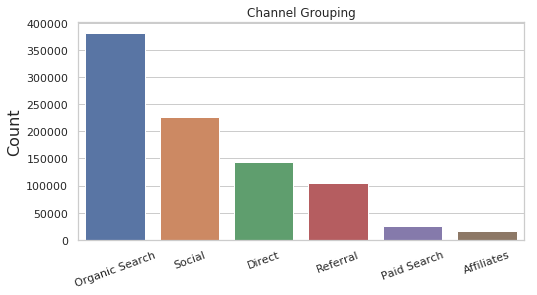

In [109]:
plot_categorical(data=train_df, col='channelGrouping',size=[8 ,4], xlabel_angle=20, title='Channel Grouping', max_cat=[0, 6])

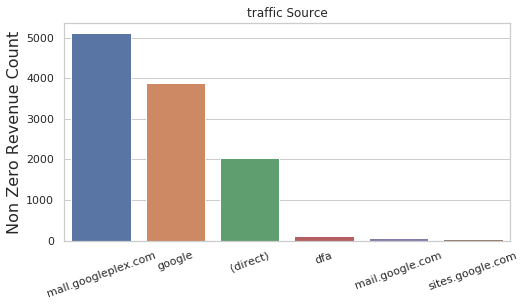

In [110]:
plot_categorical_non_zero_revenue(data=train_df, col='trafficSource.source',size=[8 ,4], xlabel_angle=20, title='traffic Source', max_cat=[0, 6])

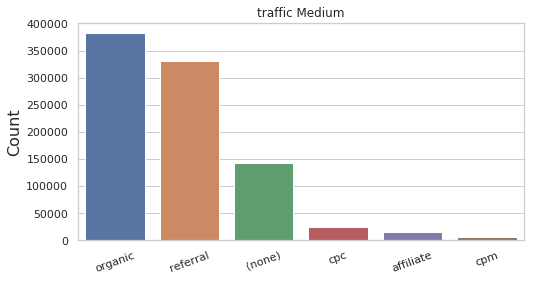

In [111]:
plot_categorical(data=train_df, col='trafficSource.medium',size=[8 ,4], xlabel_angle=20, title='traffic Medium', max_cat=[0, 6])

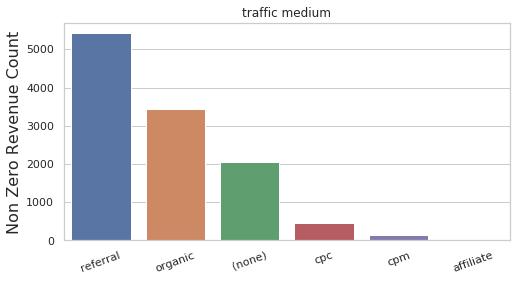

In [112]:
plot_categorical_non_zero_revenue(data=train_df, col='trafficSource.medium',size=[8 ,4], xlabel_angle=20, title='traffic medium', max_cat=[0, 6])

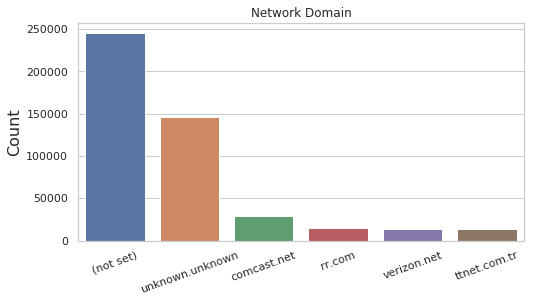

In [114]:
plot_categorical(data=train_df, col='geoNetwork.networkDomain',size=[8 ,4], xlabel_angle=20, title='Network Domain', max_cat=[0, 6])

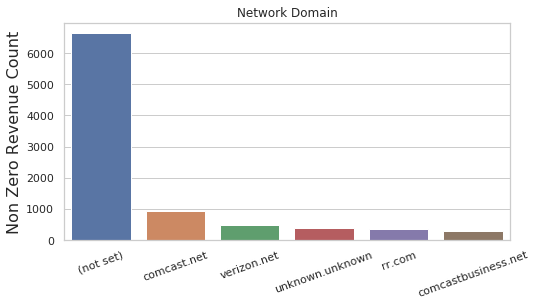

In [115]:
plot_categorical_non_zero_revenue(data=train_df, col='geoNetwork.networkDomain',size=[8 ,4], xlabel_angle=20, title='Network Domain', max_cat=[0, 6])

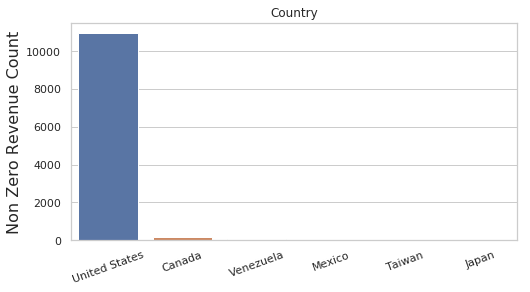

In [117]:
plot_categorical_non_zero_revenue(data=train_df, col='geoNetwork.country',size=[8 ,4], xlabel_angle=20, title='Country', max_cat=[0, 6])

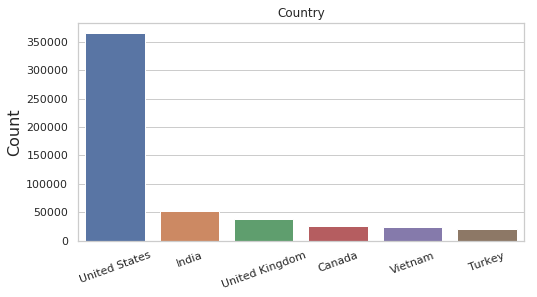

In [118]:
plot_categorical(data=train_df, col='geoNetwork.country',size=[8 ,4], xlabel_angle=20, title='Country', max_cat=[0, 6])

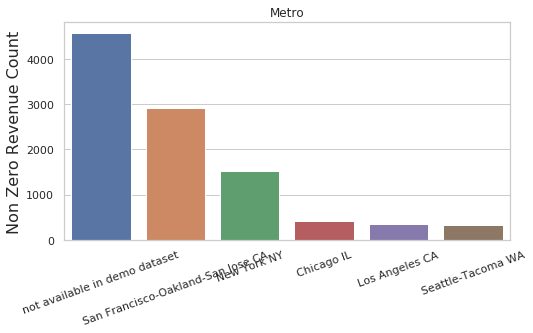

In [119]:
plot_categorical_non_zero_revenue(data=train_df, col='geoNetwork.metro',size=[8 ,4], xlabel_angle=20, title='Metro', max_cat=[0, 6])

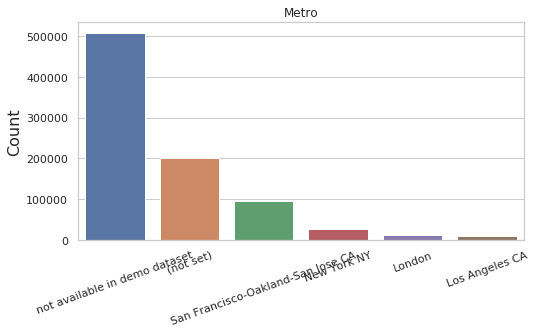

In [121]:
plot_categorical(data=train_df, col='geoNetwork.metro',size=[8 ,4], xlabel_angle=20, title='Metro', max_cat=[0, 6])

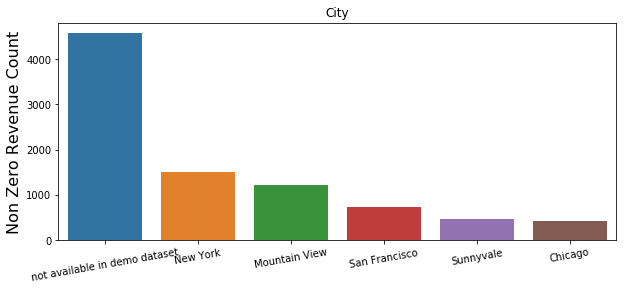

In [86]:
plot_categorical_non_zero_revenue(data=train_df, col='geoNetwork.city',size=[10 ,4], xlabel_angle=10, title='City', max_cat=[0, 6])




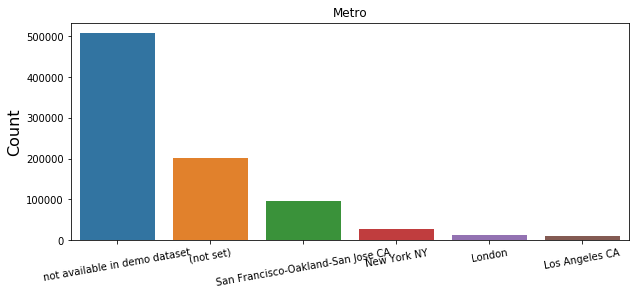

In [84]:
plot_categorical(data=train_df, col='geoNetwork.metro',size=[10 ,4], xlabel_angle=10, title='Metro', max_cat=[0, 6])

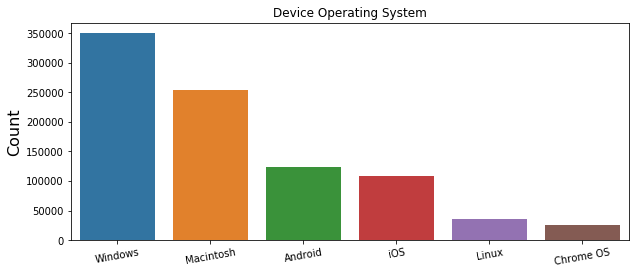

In [96]:
plot_categorical(data=train_df, col='device.operatingSystem',size=[10 ,4], xlabel_angle=10, title='Device Operating System', max_cat=[0, 6])

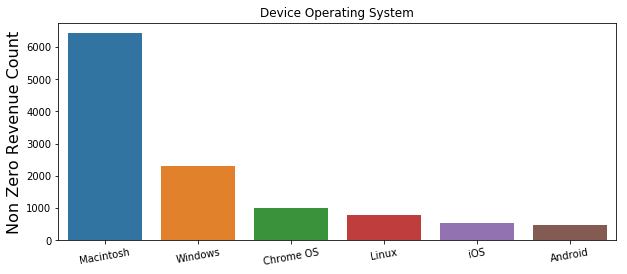

In [97]:
plot_categorical_non_zero_revenue(data=train_df, col='device.operatingSystem',size=[10 ,4], xlabel_angle=10, title='Device Operating System', max_cat=[0, 6])

In [119]:
temp = train_df.groupby('geoNetwork.continent')['totals.hits', 'visitNumber'].sum()


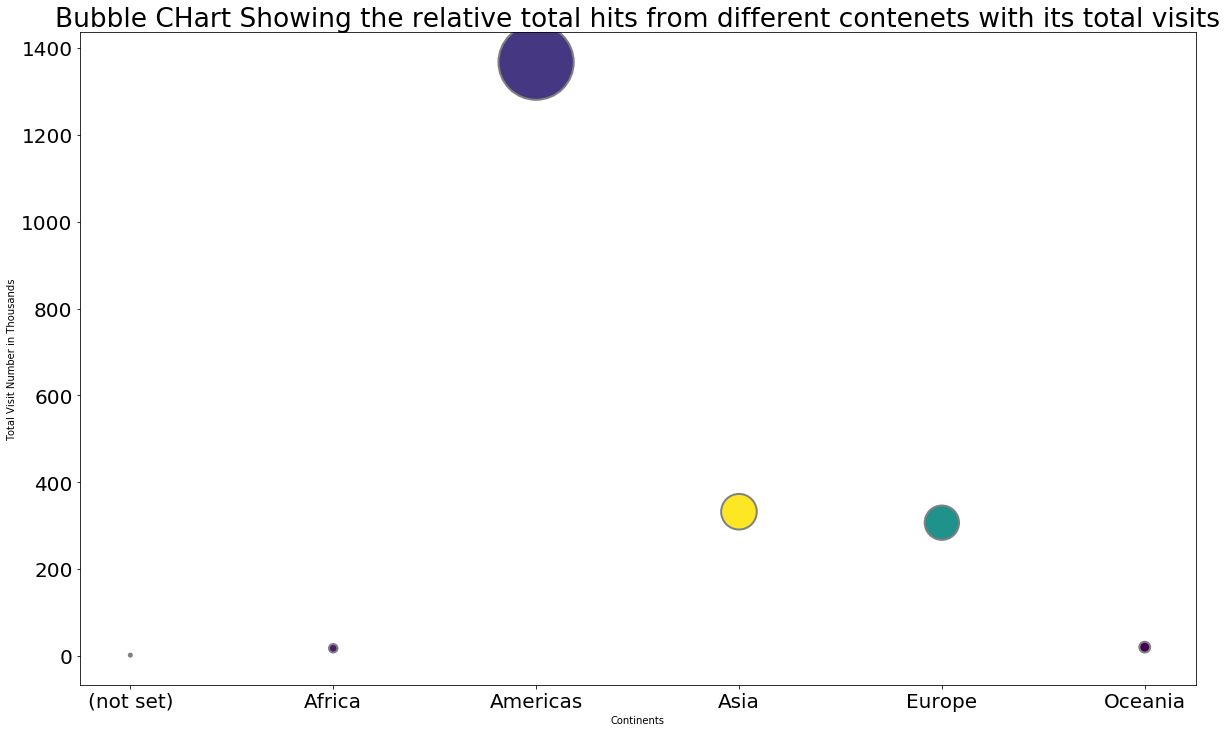

In [156]:
x = temp.index
y = temp['visitNumber']
z = temp['totals.hits']
colors = np.random.rand(6) 
 
plt.figure(figsize=(20,12))
plt.scatter(x, y/1000, s=z/500,c=colors, edgecolors="grey", linewidth=2)
 
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Continents")
plt.ylabel("Total Visit Number in Thousands")
plt.title("Bubble CHart Showing the relative total hits from different contenets with its total visits")
 
plt.show()


In [263]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,...,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,log_revenue
0,4,2016-09-02,1131660440785968503,1131660440785968503_1472830385,1472830385,1,2016-09-02 15:33:05,35,0,False,...,59008,11,3,4,1,11,5,3196,208,0.0
1,4,2016-09-02,377306020877927890,377306020877927890_1472880147,1472880147,1,2016-09-03 05:22:27,43,0,False,...,59008,11,3,4,1,11,5,3196,208,0.0
2,4,2016-09-02,3895546263509774583,3895546263509774583_1472865386,1472865386,1,2016-09-03 01:16:26,35,0,False,...,59008,11,3,4,1,11,5,3196,208,0.0
3,4,2016-09-02,4763447161404445595,4763447161404445595_1472881213,1472881213,1,2016-09-03 05:40:13,79,0,False,...,59008,11,3,4,1,1607,5,3196,208,0.0
4,4,2016-09-02,27294437909732085,27294437909732085_1472822600,1472822600,2,2016-09-02 13:23:20,35,1,True,...,59008,11,3,4,0,11,5,3196,208,0.0


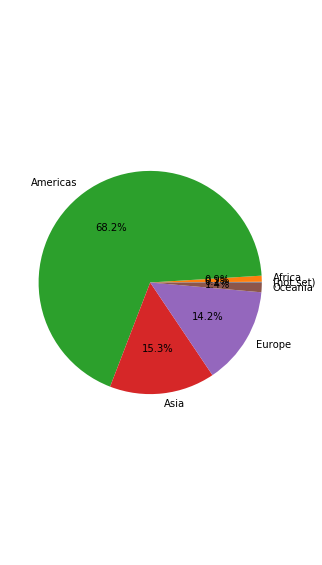

In [78]:
sums = train_df.groupby('geoNetwork.continent')['totals.hits'].sum()
fig = plt.figure(figsize=(5,10))
plt.axis('equal');
plt.pie(sums, labels=sums.index, autopct='%1.1f%%');
plt.show()

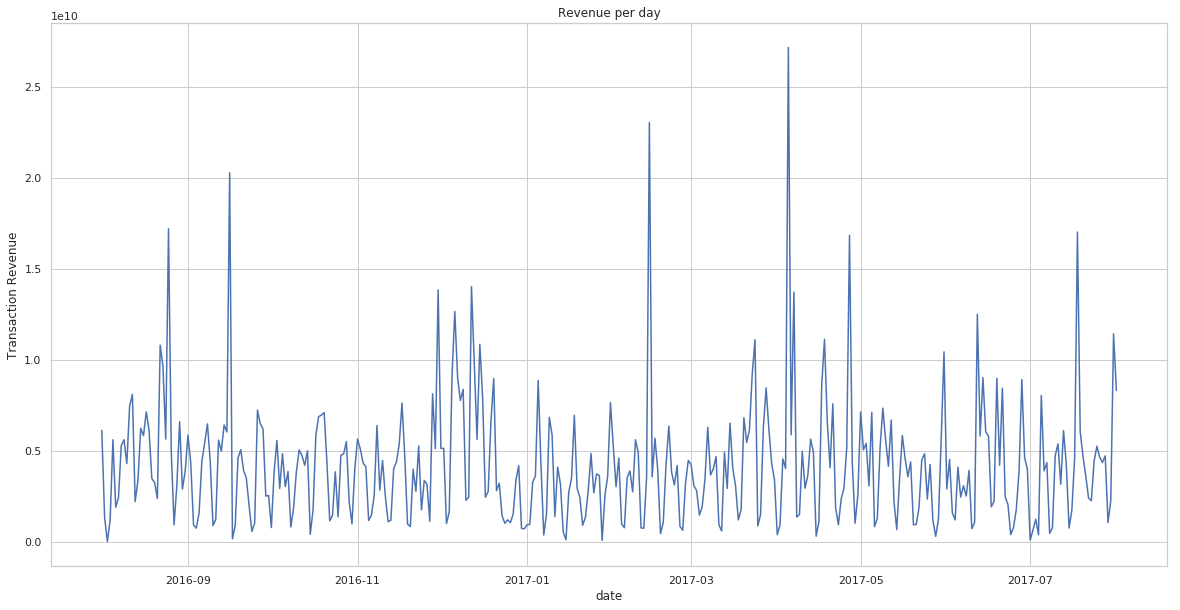

In [258]:
daily_revenue_df = train_df[["totals.transactionRevenue" , "date"]].groupby(by=["date"],axis = 0 ).sum()
fig, axes = plt.subplots(figsize=(20,10))
axes.set_title("Revenue per day")
axes.set_ylabel("Transaction Revenue")
axes.set_xlabel("date")
axes.plot(daily_revenue_df["totals.transactionRevenue"])

In [76]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,...,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,desktop,False,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,desktop,False,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
2,Organic Search,2016-09-02,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,desktop,False,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
3,Organic Search,2016-09-02,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,UC Browser,desktop,False,...,NaN,NaN,NaN,NaN,(not set),NaN,google + online,organic,NaN,google
4,Organic Search,2016-09-02,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,Chrome,mobile,True,...,NaN,NaN,NaN,NaN,(not set),1.0,(not provided),organic,NaN,google


In [23]:
train_enc = train_df.copy()

In [24]:
train_enc.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,...,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,desktop,False,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,desktop,False,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
2,Organic Search,2016-09-02,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,desktop,False,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
3,Organic Search,2016-09-02,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,UC Browser,desktop,False,...,NaN,NaN,NaN,NaN,(not set),NaN,google + online,organic,NaN,google
4,Organic Search,2016-09-02,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,Chrome,mobile,True,...,NaN,NaN,NaN,NaN,(not set),1.0,(not provided),organic,NaN,google


In [25]:
test_enc = test_df.copy()

In [26]:
test_enc.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,...,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,2017-10-16,6167871330617112363,6167871330617112363_1508151024,1508151024,2,1508151024,Chrome,desktop,False,...,NaN,NaN,NaN,NaN,(not set),1.0,(not provided),organic,NaN,google
1,Organic Search,2017-10-16,0643697640977915618,0643697640977915618_1508175522,1508175522,1,1508175522,Chrome,desktop,False,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
2,Organic Search,2017-10-16,6059383810968229466,6059383810968229466_1508143220,1508143220,1,1508143220,Chrome,desktop,False,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
3,Organic Search,2017-10-16,2376720078563423631,2376720078563423631_1508193530,1508193530,1,1508193530,Safari,mobile,True,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
4,Organic Search,2017-10-16,2314544520795440038,2314544520795440038_1508217442,1508217442,1,1508217442,Safari,desktop,False,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google


In [27]:
cat_cols = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", 
            "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", 
            "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign",
            "trafficSource.keyword", "trafficSource.medium", 
            "trafficSource.referralPath", "trafficSource.source",'trafficSource.isTrueDirect']

In [28]:
def encode_cat_col(train, test):
    for col in cat_cols:
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
        train[col] = lbl.transform(list(train[col].values.astype('str')))
        test[col] = lbl.transform(list(test[col].values.astype('str')))

In [29]:
encode_cat_col(train_enc,test_enc)

In [30]:
train_enc.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,...,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,4,2016-09-02,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,35,0,False,...,3,59008,11,3,4,1,11,5,3196,208
1,4,2016-09-02,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,43,0,False,...,3,59008,11,3,4,1,11,5,3196,208
2,4,2016-09-02,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,35,0,False,...,3,59008,11,3,4,1,11,5,3196,208
3,4,2016-09-02,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,79,0,False,...,3,59008,11,3,4,1,1607,5,3196,208
4,4,2016-09-02,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,35,1,True,...,3,59008,11,3,4,0,11,5,3196,208


In [31]:
test_enc.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,...,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,4,2017-10-16,6167871330617112363,6167871330617112363_1508151024,1508151024,2,1508151024,35,0,False,...,3,59008,11,3,4,0,11,5,3196,208
1,4,2017-10-16,0643697640977915618,0643697640977915618_1508175522,1508175522,1,1508175522,35,0,False,...,3,59008,11,3,4,1,11,5,3196,208
2,4,2017-10-16,6059383810968229466,6059383810968229466_1508143220,1508143220,1,1508143220,35,0,False,...,3,59008,11,3,4,1,11,5,3196,208
3,4,2017-10-16,2376720078563423631,2376720078563423631_1508193530,1508193530,1,1508193530,72,1,True,...,3,59008,11,3,4,1,11,5,3196,208
4,4,2017-10-16,2314544520795440038,2314544520795440038_1508217442,1508217442,1,1508217442,72,0,False,...,3,59008,11,3,4,1,11,5,3196,208


In [175]:
features = ['geoNetwork.metro','visitNumber','geoNetwork.networkDomain','device.deviceCategory',
            'totals.hits', 'totals.pageviews', 'trafficSource.source', 'trafficSource.medium','geoNetwork.city',
            'device.operatingSystem', "geoNetwork.region", "geoNetwork.subContinent", 'geoNetwork.country',
            'geoNetwork.continent', 'device.browser', 'visitStartTime']




In [33]:
train_y = np.log1p(train_enc["totals.transactionRevenue"].values)

In [176]:
dev_df = train_enc[train_enc['date']<=datetime.date(2017,5,31)]
val_df = train_enc[train_enc['date']>datetime.date(2017,5,31)]
dev_y = np.log1p(dev_df["totals.transactionRevenue"].values)
val_y = np.log1p(val_df["totals.transactionRevenue"].values)

/Users/prachi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning:

Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.

/Users/prachi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning:

Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.



In [177]:
dev_X = dev_df[features] 
val_X = val_df[features] 
test_X = test_enc[features] 

In [44]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

In [178]:

pred_test, model, pred_val = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.70027
[200]	valid_0's rmse: 1.69157
[300]	valid_0's rmse: 1.69085
Early stopping, best iteration is:
[234]	valid_0's rmse: 1.68961


In [179]:
sub_df = pd.DataFrame({"fullVisitorId":test_df.fullVisitorId})
pred_test[pred_test<0] = 0
sub_df["PredictedLogRevenue"] = np.expm1(pred_test)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.to_csv("baseline_lgb4.csv", index=False)

In [94]:
train_df['buyingScore'] = train_df['totals.transactionRevenue']/(train_df['totals.pageviews'] * train_df['totals.hits'] * train_df['visitNumber'])


In [95]:
train_df[['fullVisitorId', 'buyingScore', 'totals.pageviews','visitNumber','totals.hits','totals.transactionRevenue']].nlargest(10,'buyingScore')




,fullVisitorId,buyingScore,totals.pageviews,visitNumber,totals.hits,totals.transactionRevenue
129416,2801499422088453532,2.922222e+07,2.0,9,2,1.052000e+09
555098,7538330122216229269,2.731340e+07,5.0,2,5,1.365670e+09
629767,7496147812697146114,1.793974e+07,13.0,2,15,6.996500e+09
411258,8345665415010586104,9.006944e+06,8.0,1,9,6.485000e+08
688341,7822178141511453911,8.981250e+06,4.0,4,4,5.748000e+08
613139,5953034565631333907,5.992500e+06,2.0,1,2,2.397000e+07
533924,4474580511359381331,5.914336e+06,11.0,2,13,1.691500e+09
229439,1131086328893373855,5.509191e+06,16.0,1,17,1.498500e+09
760379,2091708218998967059,4.823077e+06,13.0,1,14,8.778000e+08
603808,2967664827442283571,4.786777e+06,11.0,1,11,5.792000e+08


In [92]:
train_df['buyingScore'] = train_df['totals.transactionRevenue']/train_df['visitNumber']



In [93]:
train_df[['fullVisitorId', 'buyingScore', 'totals.pageviews','visitNumber','totals.hits','totals.transactionRevenue']].nlargest(10,'buyingScore')

,fullVisitorId,buyingScore,totals.pageviews,visitNumber,totals.hits,totals.transactionRevenue
822980,4604965471651937146,4.280700e+09,38.0,1,57,4.280700e+09
532690,6236695646664370912,4.009560e+09,49.0,1,71,4.009560e+09
629767,7496147812697146114,3.498250e+09,13.0,2,15,6.996500e+09
380988,5632276788326171571,3.204750e+09,89.0,5,136,1.602375e+10
568103,4759981878863963838,3.026100e+09,78.0,1,116,3.026100e+09
679653,9417857471295131045,2.548500e+09,109.0,1,156,2.548500e+09
367396,8161635015929084485,2.545000e+09,61.0,1,81,2.545000e+09
397782,8076486872734382011,2.438870e+09,115.0,1,170,2.438870e+09
773728,875410720669459903,2.407200e+09,40.0,1,56,2.407200e+09
715269,3769632740374536577,2.136000e+09,22.0,2,34,4.272000e+09


In [208]:
val_rank['buyingScore'] = val_rank['totals.transactionRevenue']/val_rank['visitNumber']



/Users/prachi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [210]:
val_rank[['fullVisitorId', 'buyingScore', 'totals.pageviews','visitNumber','totals.hits','totals.transactionRevenue']].nlargest(10,'buyingScore')

,fullVisitorId,buyingScore,totals.pageviews,visitNumber,totals.hits,totals.transactionRevenue
822980,4604965471651937146,4.280700e+09,38.0,1,57,4.280700e+09
532690,6236695646664370912,4.009560e+09,49.0,1,71,4.009560e+09
679653,9417857471295131045,2.548500e+09,109.0,1,156,2.548500e+09
773728,875410720669459903,2.407200e+09,40.0,1,56,2.407200e+09
773715,9417857471295131045,1.323642e+09,30.0,8,41,1.058914e+10
73912,3948936105865802619,1.271190e+09,47.0,1,51,1.271190e+09
572866,79204932396995037,1.041458e+09,23.0,6,31,6.248750e+09
712530,4030851960983791121,9.956800e+08,24.0,1,34,9.956800e+08
551492,397440133393463294,8.995000e+08,26.0,1,35,8.995000e+08
849550,9547536437145935282,8.628000e+08,35.0,1,50,8.628000e+08


In [57]:
product_df =  pd.read_csv('product_revenue.csv')
product_df.head()

,yitemrevenue,xcartadd,xcartuniqadd,xcartaddtotalrs,xcartremove,xcardtremovetotal,xcardtremovetotalrs,xproductviews,xuniqprodview,xprodviewinrs
0,39215.93,614,503,752186,10,10,11990,24306,20498,299
1,23819.47,833,622,425667,8,5,3992,11171,8718,571
2,4415.45,122,101,121878,2,2,1998,6926,6017,6919074
3,57435.56,239,196,609761,2,2,4998,11250,9733,2834
4,0.00,32,22,58488,0,0,0,872,764,1745628


In [58]:
product_df.shape

(92, 10)

In [59]:
product_df['xproductviews'].corr(product_df['yitemrevenue'])

0.7566538161781481

In [60]:
product_df['xuniqprodview'].corr(product_df['yitemrevenue'])

0.7579415094255393

In [61]:
product_df['rev_view_ratio'] = product_df['yitemrevenue']/product_df['xproductviews']

In [62]:
product_df['rev_view_ratio'].describe()

count    92.000000
mean      2.839249
std       4.364241
min       0.000000
25%       0.000000
50%       1.300763
75%       3.858306
max      27.565012
Name: rev_view_ratio, dtype: float64

In [69]:
product_df['xproductviews'].corr(product_df['xcartadd'])

0.8450201375855705

In [63]:
product_df['cartAdd_view_ratio'] = product_df['xcartadd']/product_df['xproductviews']

In [64]:
product_df['cartAdd_view_ratio'].describe()

count    92.000000
mean      0.027303
std       0.023131
min       0.000000
25%       0.010039
50%       0.021687
75%       0.036889
max       0.130435
Name: cartAdd_view_ratio, dtype: float64

In [53]:
perm_features = ['channelGrouping','geoNetwork.metro','visitNumber','geoNetwork.networkDomain','device.deviceCategory',
                 'totals.hits', 'totals.pageviews', 'trafficSource.source', 'trafficSource.medium','geoNetwork.city',
                 'device.operatingSystem', "geoNetwork.region", "geoNetwork.subContinent", 'geoNetwork.country',
                 'geoNetwork.continent', 'device.browser','visitStartTime', 'device.isMobile']


In [54]:
dev_X = dev_df[perm_features] 
val_X = val_df[perm_features] 
test_X = test_enc[perm_features] 
pred_test, model, pred_val = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.69392
[200]	valid_0's rmse: 1.68942
[300]	valid_0's rmse: 1.6901
Early stopping, best iteration is:
[276]	valid_0's rmse: 1.68899


In [52]:
perm_features = ['channelGrouping','geoNetwork.metro','visitNumber','geoNetwork.networkDomain','device.deviceCategory',
                 'totals.hits', 'totals.pageviews', 'trafficSource.source', 'trafficSource.medium','geoNetwork.city',
                 'device.operatingSystem', "geoNetwork.region", "geoNetwork.subContinent", 'geoNetwork.country',
                 'geoNetwork.continent', 'device.browser','visitStartTime']


In [51]:
dev_X = dev_df[perm_features] 
val_X = val_df[perm_features] 
test_X = test_enc[perm_features] 
pred_test, model, pred_val = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.69894
[200]	valid_0's rmse: 1.69336
[300]	valid_0's rmse: 1.6915
Early stopping, best iteration is:
[256]	valid_0's rmse: 1.69062


In [159]:
perm_features = ['channelGrouping','geoNetwork.metro','visitNumber','geoNetwork.networkDomain','device.deviceCategory',
                 'totals.hits', 'totals.pageviews', 'trafficSource.source', 'trafficSource.medium','geoNetwork.city',
                 'device.operatingSystem', "geoNetwork.region", "geoNetwork.subContinent", 'geoNetwork.country',
                 'device.browser', 'visitStartTime']
dev_X = dev_df[perm_features] 
val_X = val_df[perm_features] 
test_X = test_enc[perm_features] 
pred_test, model, pred_val = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.70417
[200]	valid_0's rmse: 1.69371
[300]	valid_0's rmse: 1.69264
Early stopping, best iteration is:
[274]	valid_0's rmse: 1.69205


In [160]:
perm_features = ['geoNetwork.metro','visitNumber','geoNetwork.networkDomain','device.deviceCategory', 'totals.hits', 'totals.pageviews', 'trafficSource.source', 'trafficSource.medium','geoNetwork.city', 'device.operatingSystem', "geoNetwork.region", 
            "geoNetwork.subContinent", 'geoNetwork.country', 'geoNetwork.continent','device.browser','visitStartTime']
dev_X = dev_df[perm_features] 
val_X = val_df[perm_features] 
test_X = test_enc[perm_features] 
pred_test, model, pred_val = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.70027
[200]	valid_0's rmse: 1.69157
[300]	valid_0's rmse: 1.69085
Early stopping, best iteration is:
[234]	valid_0's rmse: 1.68961


In [161]:
perm_features = ['channelGrouping','geoNetwork.metro','visitNumber','device.deviceCategory', 'totals.hits', 'totals.pageviews', 'trafficSource.source', 'trafficSource.medium','geoNetwork.city', 'device.operatingSystem', "geoNetwork.region", 
            "geoNetwork.subContinent", 'geoNetwork.country', 'geoNetwork.continent','device.browser', 'visitStartTime']
dev_X = dev_df[perm_features] 
val_X = val_df[perm_features] 
test_X = test_enc[perm_features] 
pred_test, model, pred_val = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.69959
[200]	valid_0's rmse: 1.69189
[300]	valid_0's rmse: 1.69181
Early stopping, best iteration is:
[245]	valid_0's rmse: 1.69037


In [162]:
perm_features = ['channelGrouping','geoNetwork.metro','visitNumber','device.deviceCategory', 'totals.hits', 'totals.pageviews', 'trafficSource.source', 'geoNetwork.city', 'device.operatingSystem', "geoNetwork.region", 
            "geoNetwork.subContinent", 'geoNetwork.country', 'geoNetwork.continent','device.browser','geoNetwork.networkDomain', 'visitStartTime']
dev_X = dev_df[perm_features] 
val_X = val_df[perm_features] 
test_X = test_enc[perm_features] 
pred_test, model, pred_val = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.70184
[200]	valid_0's rmse: 1.69363
[300]	valid_0's rmse: 1.6903
Early stopping, best iteration is:
[282]	valid_0's rmse: 1.68968


In [163]:
perm_features = ['channelGrouping','geoNetwork.metro','visitNumber', 'totals.hits', 'totals.pageviews', 'trafficSource.source','trafficSource.medium', 'geoNetwork.city', 'device.operatingSystem', "geoNetwork.region", 
            "geoNetwork.subContinent", 'geoNetwork.country', 'geoNetwork.continent','device.browser','geoNetwork.networkDomain', 'visitStartTime']
dev_X = dev_df[perm_features] 
val_X = val_df[perm_features] 
test_X = test_enc[perm_features] 
pred_test, model, pred_val = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.69973
[200]	valid_0's rmse: 1.69334
[300]	valid_0's rmse: 1.69418
Early stopping, best iteration is:
[246]	valid_0's rmse: 1.69291


In [167]:
perm_features = ['channelGrouping','geoNetwork.metro','visitNumber', 'totals.pageviews', 'trafficSource.source','trafficSource.medium', 'geoNetwork.city', 'device.deviceCategory','device.operatingSystem', "geoNetwork.region", 
            "geoNetwork.subContinent", 'geoNetwork.country', 'geoNetwork.continent','device.browser','geoNetwork.networkDomain', 'visitStartTime']
dev_X = dev_df[perm_features] 
val_X = val_df[perm_features] 
test_X = test_enc[perm_features] 
pred_test, model, pred_val = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.72314
[200]	valid_0's rmse: 1.72218
Early stopping, best iteration is:
[130]	valid_0's rmse: 1.72193


In [170]:
perm_features = ['channelGrouping','geoNetwork.metro','visitNumber', 'totals.hits','totals.pageviews', 'trafficSource.source','trafficSource.medium', 'geoNetwork.city', 'device.deviceCategory','device.operatingSystem', "geoNetwork.region", 
            "geoNetwork.subContinent", 'geoNetwork.country', 'geoNetwork.continent','device.browser','geoNetwork.networkDomain']
dev_X = dev_df[perm_features] 
val_X = val_df[perm_features] 
test_X = test_enc[perm_features] 
pred_test, model, pred_val = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.72062
[200]	valid_0's rmse: 1.71649
[300]	valid_0's rmse: 1.71732
Early stopping, best iteration is:
[258]	valid_0's rmse: 1.71553


In [172]:
perm_features = ['geoNetwork.metro','visitNumber','geoNetwork.networkDomain','device.deviceCategory', 'totals.hits', 'totals.pageviews', 'trafficSource.source', 'trafficSource.medium','geoNetwork.city', 'device.operatingSystem', "geoNetwork.region", 
            "geoNetwork.subContinent", 'geoNetwork.country', 'geoNetwork.continent','device.browser','visitStartTime']
dev_X = dev_df[perm_features] 
val_X = val_df[perm_features] 
test_X = test_enc[perm_features] 
pred_test, model, pred_val = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.70027
[200]	valid_0's rmse: 1.69157
[300]	valid_0's rmse: 1.69085
Early stopping, best iteration is:
[234]	valid_0's rmse: 1.68961


In [174]:
sub_df = pd.DataFrame({"fullVisitorId":test_df.fullVisitorId})
pred_test[pred_test<0] = 0
sub_df["PredictedLogRevenue"] = np.expm1(pred_test)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.to_csv("baseline_lgb4.csv", index=False)